## ddqc Tutorial
First, lets set up the workspace loading the ddqc and pegasus packages

In [1]:
import pegasus as pg
import ddqc

### Reading the data
For this tutorial we will use the Human Bone Marrow dataset provided by pegasus. <br>
We will download the dataset using the following command:

In [2]:
!curl https://storage.googleapis.com/terra-featured-workspaces/Cumulus/MantonBM_nonmix_subset.zarr.zip -o MantonBM_nonmix_subset.zarr.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 81.2M  100 81.2M    0     0  2455k      0  0:00:33  0:00:33 --:--:-- 2617k


We will first load the data using the standard `read_input` pegasus function.

In [3]:
data = pg.read_input("MantonBM_nonmix_subset.zarr.zip")
data

2021-04-06 18:18:47,290 - pegasusio.readwrite - INFO - zarr file 'MantonBM_nonmix_subset.zarr.zip' is loaded.
2021-04-06 18:18:47,290 - pegasusio.readwrite - INFO - Function 'read_input' finished in 0.22s.


MultimodalData object with 1 UnimodalData: 'GRCh38-rna'
    It currently binds to UnimodalData object GRCh38-rna

UnimodalData object with n_obs x n_vars = 48219 x 36601
    Genome: GRCh38; Modality: rna
    It contains 1 matrix: 'X'
    It currently binds to matrix 'X' as X

    obs: 'n_genes', 'Channel'
    var: 'featureid'
    obsm: 
    varm: 
    uns: 'genome', 'modality'

### Biology-centered data-driven quality control (ddqc)
ddqc does adaptive quality control by clustering cells and picking a separate threshold for each cluster. It is described down below:
- Initial Qualtity Control (QC) is performed, when obvious low-quality cells are removed. By default those are cells with n_genes < 100 and percent_mito > 80.
- The cells are clustered with the clustering resolution 1.3 (default)
- Then thesholds are picked for each cluster. By default the following metrics are considered:
    - **Number of counts/UMIs**: keep cells that have n_counts greater than median - 2 Median Absolute Deviations (MAD)
    - **Number of genes**: keep cells that have n_genes greater than median - 2 MADs
    - **Percent of mitochondrial transctipts**: keep cells that have percent_mito less than median + 2 MADs
- In order to prevent the removal of healthy cells in clusters with high median n_genes and low percent_mito there are additional bounds for those thresholds:
    - Cluster-level threshold for n_genes can't be greater than 200 (default). If it is greater, it will be set to 200.
    - Cluster-level threshold for percent_mito can't be lower than 10 (default). If it is lower, it will be set to 200.

To perform ddqc on a dataset, we will run the `ddqc_metrics` function. 

If you want to customize the filtering you can use the following parameters:
- `res`: float - clustering resolution (default: 1.3)
- `method`: string - statistic on which the threshold would be calculated (default: "mad", available options "mad", "outlier")
- `threshold`: float - parameter for the selected method (default: 2)
- `basic_n_genes`: int - parameter for the initial QC n_genes filtering (default: 100)
- `basic_percent_mito`: float - parameter for the initial QC percent_mito filtering (default: 80)
- `mito_prefix`: string - gene prefix used to calculate percent_mito in a cell (default: "MT-")
- `ribo_prefix`: string - gene regular expression used to calculate percent_ribo in a cell (default: "^RP[SL][[:digit:]]|^RPLP[[:digit:]]|^RPSA")
- `do_counts`: bool - whether to consider n_counts for ddqc (default: True)
- `do_genes`: bool - whether to consider n_genes for ddqc (default: True)
- `do_mito`: bool - whether to consider percent_mito for ddqc (default: True)
- `do_ribo`: bool - whether to consider percent_ribo for ddqc (default: False)
- `n_genes_lower_bound`: int - bound for lower n_genes cluster-level threshold (default: 200)
- `basic_percent_mito`: float - bound for upper percent_mito cluster-level threshold (default: 10)
- `random_state`: int - random seed for clustering results reproducibility (default: 29)
- `return_df_qc`: bool - whether to return a dataframe with the information about on what metric and what threshold the cell was removed for each removed cell. (default: True)

We will now run ddqc on the dataset with default settings.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ddqc/ddqc.py:20: FutureWarning: Possible nested set at position 8
  data.var_names.map(lambda x: re.match(ribo_prefix, x, flags=re.IGNORECASE) is not None).values.nonzero()[
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ddqc/ddqc.py:20: FutureWarning: Possible nested set at position 25
  data.var_names.map(lambda x: re.match(ribo_prefix, x, flags=re.IGNORECASE) is not None).values.nonzero()[


2021-04-06 18:18:48,154 - pegasusio.qc_utils - INFO - After filtration, 48210 out of 48219 cell barcodes are kept in UnimodalData object GRCh38-rna.
2021-04-06 18:18:48,154 - pegasus.tools.preprocessing - INFO - Function 'filter_data' finished in 0.27s.
2021-04-06 18:18:48,862 - pegasus.tools.preprocessing - INFO - After filtration, 25910/36601 genes are kept. Among 25910 genes, 16967 genes are robust.
2021-04-06 18:18:48,863 - pegasus.tools.preprocessing - INFO - Function 'identify_robust_genes' finished in 0.71s.
2021-04-06 18:18:49,504 - pegasus.tools.preprocessing - INFO - Function 'log_norm' finished in 0.64s.
2021-04-06 18:18:49,627 - pegasus.tools.hvf_selection - INFO - Function 'estimate_feature_statistics' finished in 0.12s.
2021-04-06 18:18:49,670 - pegasus.tools.hvf_selection - INFO - 2000 highly variable features have been selected.
2021-04-06 18:18:49,671 - pegasus.tools.hvf_selection - INFO - Function 'highly_variable_features' finished in 0.17s.
2021-04-06 18:19:01,692 -

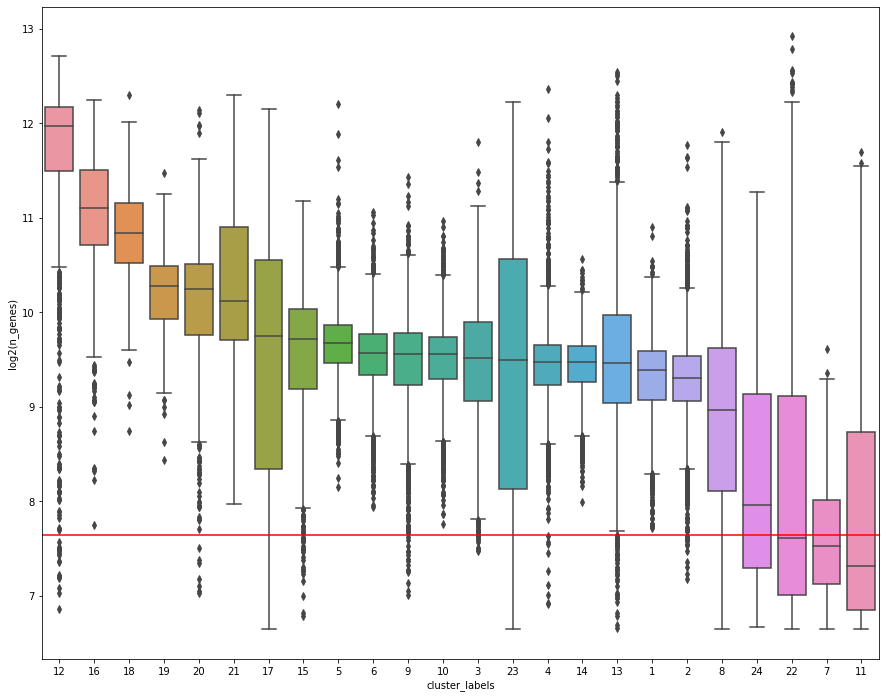

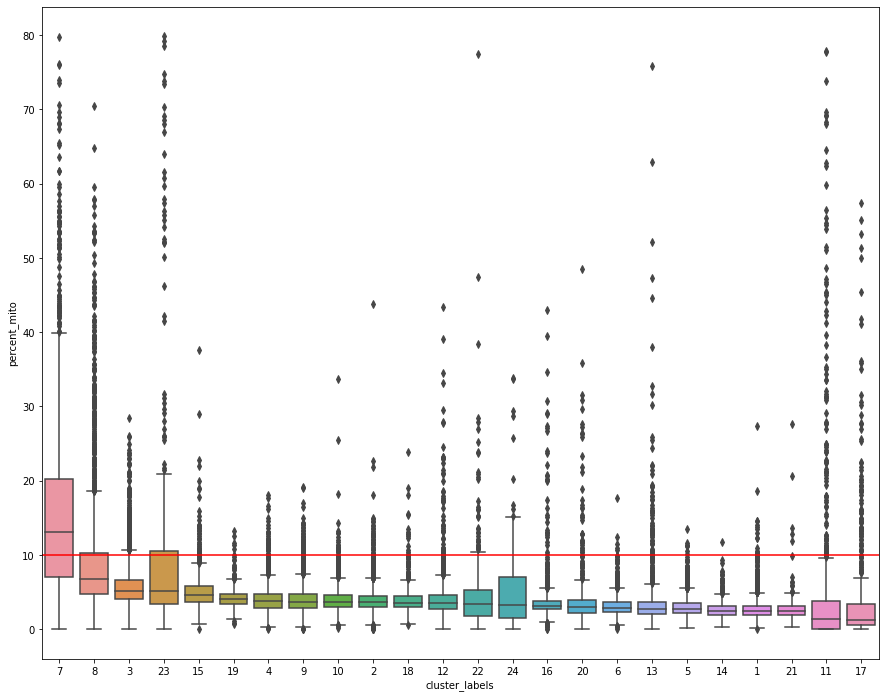

In [4]:
df_qc = ddqc.ddqc_metrics(data, return_df_qc=True)

### Outputs
There are two boxplots provided for exploratory data analysis:
- log2(n_genes) by cluster: shows log2 of number of genes for each cluster in the initial clustering. Red line at 200 genes (7.64 in log2 scale) represents the most common fixed threshold cutoff for n_genes.
- percent_mito by cluster: shows percent_mito for each cluster in the initial clustering. Red line at 10% represents the most common fixed threshold cutoff for percent_mito.

If you requested to return df_qc the function will return a pandas dataframe containing the following info for each cell:
- `cluster_labels`: cluster from initial clustering performed by ddqc
- `metric_lower_co` and `metric_upper_co`: lower and upper cuttofs for each metric on which ddqc was performed. If ddqc was not performed for upper or lower end of this metric this field will be `None`
This information is useful if you want to understand based on which metric the cell was filtered out.

In [5]:
df_qc

,cluster_labels,n_counts_lower_co,n_counts_upper_co,n_counts,n_counts_passed_qc,n_genes_lower_co,n_genes_upper_co,n_genes,n_genes_passed_qc,percent_mito_lower_co,percent_mito_upper_co,percent_mito,percent_mito_passed_qc,passed_qc
barcodekey,,,,,,,,,,,,,,
MantonBM1_HiSeq_1-AAACCTGAGCAGGTCA,6,1359.2792,None,3554.0,True,200,None,816.0,True,None,10,3.967361,True,True
MantonBM1_HiSeq_1-AAACCTGCACACTGCG,3,-464.3688,None,1740.0,True,111.2732,None,716.0,True,None,10,6.034483,True,True
MantonBM1_HiSeq_1-AAACCTGCACCGGAAA,1,731.1666,None,2435.0,True,200,None,554.0,True,None,10,2.751540,True,True
MantonBM1_HiSeq_1-AAACCTGCATAGACTC,4,729.4072,None,2913.0,True,200,None,967.0,True,None,10,3.329900,True,True
MantonBM1_HiSeq_1-AAACCTGCATCGATGT,13,-335.4844,None,5372.0,True,77.3428,None,1704.0,True,None,10,2.122115,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MantonBM8_HiSeq_1-TTTGTCAGTCCGACGT,1,731.1666,None,1570.0,True,200,None,454.0,True,None,10,3.566879,True,True
MantonBM8_HiSeq_1-TTTGTCAGTCGCGGTT,3,-464.3688,None,1367.0,True,111.2732,None,539.0,True,None,10,7.388442,True,True
MantonBM8_HiSeq_1-TTTGTCAGTGGTGTAG,3,-464.3688,None,3834.0,True,111.2732,None,1117.0,True,None,10,2.973396,True,True


### Filter out the cells
Now, we will filter out the cells that failed ddqc. Here, we started with 48219 cells and retain 45939 cells.

In [6]:
pg.filter_data(data)

2021-04-06 18:19:30,544 - pegasusio.qc_utils - INFO - After filtration, 45939 out of 48210 cell barcodes are kept in UnimodalData object GRCh38-rna.
2021-04-06 18:19:30,545 - pegasus.tools.preprocessing - INFO - Function 'filter_data' finished in 0.33s.


### Save the dataset
We will save the dataset as data.h5ad, which can then be imported into the scRNAseq pipeline of your choice for downstream analysis.

In [7]:
pg.write_output(data, "data.h5ad")

2021-04-06 18:19:38,147 - pegasusio.readwrite - INFO - h5ad file 'data.h5ad' is written.
2021-04-06 18:19:38,148 - pegasusio.readwrite - INFO - Function 'write_output' finished in 7.60s.
